ライブラリインストール

In [1]:
import pandas as pd
import numpy as np

#import pycaret

#setup関数をimport
#from pycaret.regression import setup

#compare_models関数は、ライブラリ内のすべてのモデルを使って訓練を行い、スコアを評価する。
#回帰問題なので'refression'を指定
#from pycaret.regression import compare_models

#models関数により、すべての使用可能な機械学習モデルを確認できる。
#from pycaret.regression import models

#ceate_model関数:「交差検証」を用いて個別のモデルの訓練と評価を行う。  
#from pycaret.regression import create_model

#tune_model関数を用いて、ハイパーパラメータを最適化する。
#from pycaret.regression import tune_model

#plot_model関数を使い、各特徴量の重要度をプロットする、
#from pycaret.regression import plot_model

#finalize_model関数により、すべての訓練データを使ってモデルを訓練し、本番用のモデルを作成できるようにする。
#from pycaret.regression import finalize_model

#from pycaret.regression import predict_model

import lightgbm as lgb
from sklearn import metrics
from scipy.stats import rankdata
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.simplefilter('ignore', FutureWarning)

import re
import pickle
import seaborn as sns
import lightgbm as lgb
#import japanize_matplotlib
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

import copy

# XGBoostのライブラリのインポート
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

## 検証11  
### XGBoostに前処理をして改めて、やってみる。

In [23]:
#前処理

#trainデータ処理
train_df = pd.read_table('train.tsv')
#One-Hot Encoding
train_df_one_hot_encoded = pd.get_dummies(train_df,columns=['weathersit'])
#曜日の'weekday'を土日(0)と平日(1)の2値データする。
#新しい変数'weekday2'を作って、全て0(zero)を入れる
train_df_one_hot_encoded['weekday2'] = 0
#平日を1にしたいので、1にするコードを用意する
train_df_one_hot_encoded.loc[train_df_one_hot_encoded['weekday'].isin(list(range(1,6))),'weekday2']=1
# 結果の件数を確認する
#train_df_one_hot_encoded['weekday2'].value_counts()
# id2500以前は、傾向が違うため、カット(運用開始など？)
train_df_one_hot_encoded = train_df_one_hot_encoded[train_df_one_hot_encoded['id'] > 2500]


#testデータ処理
test_df = pd.read_table('test.tsv')
#One-Hot Encoding
test_df_one_hot_encoded = pd.get_dummies(test_df,columns=['weathersit'])
#曜日の'weekday'を土日(0)と平日(1)の2値データする。
#新しい変数'weekday2'を作って、全て0(zero)を入れる
test_df_one_hot_encoded['weekday2'] = 0
#平日を1にしたいので、1にするコードを用意する
test_df_one_hot_encoded.loc[test_df_one_hot_encoded['weekday'].isin(list(range(1,6))),'weekday2']=1


In [24]:
train_df_one_hot_encoded

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,weathersit_1,weathersit_2,weathersit_3,weathersit_4,weekday2
2500,2501,2011-04-19,2,0,4,2,0,2,1,0.46,0.4545,0.67,0.2836,13,1,0,0,0,1
2501,2502,2011-04-19,2,0,4,3,0,2,1,0.48,0.4697,0.63,0.2239,3,1,0,0,0,1
2502,2503,2011-04-19,2,0,4,4,0,2,1,0.46,0.4545,0.67,0.0896,5,1,0,0,0,1
2503,2504,2011-04-19,2,0,4,5,0,2,1,0.46,0.4545,0.72,0.1940,18,0,1,0,0,1
2504,2505,2011-04-19,2,0,4,6,0,2,1,0.48,0.4697,0.67,0.0000,65,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8640,8641,2011-12-31,1,0,12,19,0,6,0,0.42,0.4242,0.54,0.2239,92,1,0,0,0,0
8641,8642,2011-12-31,1,0,12,20,0,6,0,0.42,0.4242,0.54,0.2239,71,1,0,0,0,0
8642,8643,2011-12-31,1,0,12,21,0,6,0,0.40,0.4091,0.58,0.1940,52,1,0,0,0,0
8643,8644,2011-12-31,1,0,12,22,0,6,0,0.38,0.3939,0.62,0.1343,38,1,0,0,0,0


In [25]:
# 説明変数、目的変数を格納
X = train_df_one_hot_encoded.drop(['id','dteday','cnt'], axis=1)
y = train_df_one_hot_encoded['cnt']
X_test = test_df_one_hot_encoded.drop(['id','dteday'], axis=1)

In [3]:
#説明変数と目的変数を用意
#season,yr,mmth,holiday,weekday,workingday
#X = train_df_one_hot_encoded[['hr','temp','atemp','weathersit_1','weathersit_2','weathersit_3']]
#y = train_df_one_hot_encoded['cnt']

In [26]:
# train dataをtrain dataとtest dataに分ける。
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42, shuffle=False)


In [27]:
# xgboostモデルの作成
reg = xgb.XGBRegressor()

In [28]:
# ハイパーパラメータ探索
reg_cv = GridSearchCV(reg, {'max_depth': [2,4,6], 'n_estimators': [50,100,200]}, verbose=1)
reg_cv.fit(train_X, train_y)
print(reg_cv.best_params_, reg_cv.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    8.7s finished


{'max_depth': 6, 'n_estimators': 50} 0.9037308995841448


In [29]:
# 改めて最適パラメータで学習
reg = xgb.XGBRegressor(**reg_cv.best_params_)
reg.fit(train_X, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

## モデルの確認

In [30]:
# 学習データを使って予測
pred_test_y = reg.predict(test_X)

In [31]:
pred_test_y

array([253.68558, 188.91656,  78.29206, ..., 154.02953, 111.80819,
        72.43422], dtype=float32)

<AxesSubplot:>

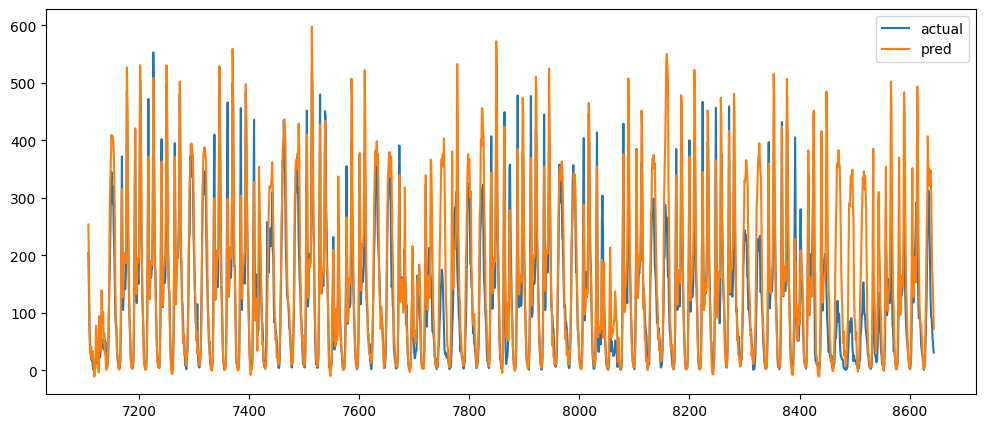

In [32]:
# 予測値が妥当か確認
train_value = train_y.values
_df = pd.DataFrame({'actual':test_y,'pred':pred_test_y})
_df.plot(figsize=(12,5))

おおむね、正しく予測出来てそう

### 特徴量の重要度確認

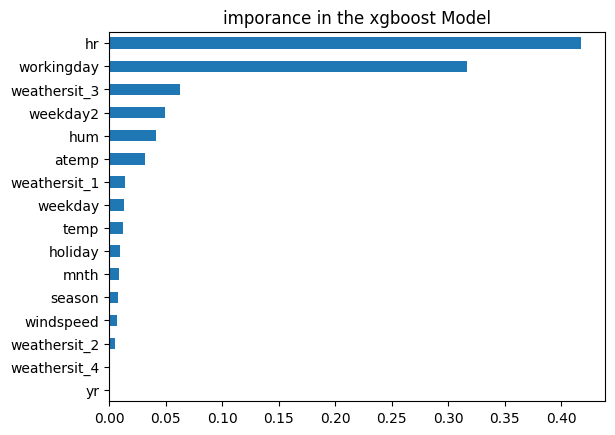

In [33]:
# feature importance のプロット
importances = pd.Series(reg.feature_importances_, index = train_X.columns)
importances = importances.sort_values()
importances.plot(kind = "barh")
plt.title("imporance in the xgboost Model")
plt.show()

時間が大きくかかわっていることがわかる。

In [34]:
from sklearn.metrics import mean_squared_error
# RMSE計算
rmse = np.sqrt(mean_squared_error(test_y, pred_test_y))
print('RMSE : {:.3f}'.format(rmse))


RMSE : 72.230


わりと良さそうだが、
前処理前のXGboostの方が良い、

### 提出ファイルの作成

In [35]:
# テストデータに対し予測値の算出
pred_test = reg.predict(X_test)

In [36]:
pred_test

array([ 76.47401 ,  54.40468 ,  36.867966, ..., 133.05652 ,  83.9906  ,
        62.701397], dtype=float32)

In [37]:
sub = test_df.copy()
sub['cnt'] = pred_test
sub.head(5)

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,8646,2012-01-01,1,1,1,0,0,0,0,1,0.36,0.3788,0.66,0.0000,76.474007
1,8647,2012-01-01,1,1,1,1,0,0,0,1,0.36,0.3485,0.66,0.1343,54.404678
2,8648,2012-01-01,1,1,1,2,0,0,0,1,0.32,0.3485,0.76,0.0000,36.867966
3,8649,2012-01-01,1,1,1,3,0,0,0,1,0.30,0.3333,0.81,0.0000,27.706715
4,8650,2012-01-01,1,1,1,4,0,0,0,1,0.28,0.3030,0.81,0.0896,6.790998


In [38]:
# 提出ファイル
sub[['id','cnt']].to_csv('sample_submit_11.csv', index=False, header = False)

In [39]:
sample_submit_11 = pd.read_csv('sample_submit_11.csv')
sample_submit_11.head(5)

,8646,76.47401
0,8647,54.404680
1,8648,36.867966
2,8649,27.706715
3,8650,6.790998
4,8651,6.503993


### 評価  
RMSE  112.9892893(125/1246位)  
特徴量を整理することで、処理の前より、精度が3ほど上がった。  
別の学習モデルやアンサンブル学習などいろいろ出来そう。

# 検証12

### lightBGMに検証10とおなじ前処理をしてみる。

In [2]:
#前処理

#trainデータ処理
train_df = pd.read_table('train.tsv')
#One-Hot Encoding
train_df_one_hot_encoded = pd.get_dummies(train_df,columns=['weathersit'])
#曜日の'weekday'を土日(0)と平日(1)の2値データする。
#新しい変数'weekday2'を作って、全て0(zero)を入れる
train_df_one_hot_encoded['weekday2'] = 0
#平日を1にしたいので、1にするコードを用意する
train_df_one_hot_encoded.loc[train_df_one_hot_encoded['weekday'].isin(list(range(1,6))),'weekday2']=1
# 結果の件数を確認する
#train_df_one_hot_encoded['weekday2'].value_counts()
# id2500以前は、傾向が違うため、カット(運用開始など？)
train_df_one_hot_encoded = train_df_one_hot_encoded[train_df_one_hot_encoded['id'] > 2500]


#testデータ処理
test_df = pd.read_table('test.tsv')
#One-Hot Encoding
test_df_one_hot_encoded = pd.get_dummies(test_df,columns=['weathersit'])
#曜日の'weekday'を土日(0)と平日(1)の2値データする。
#新しい変数'weekday2'を作って、全て0(zero)を入れる
test_df_one_hot_encoded['weekday2'] = 0
#平日を1にしたいので、1にするコードを用意する
test_df_one_hot_encoded.loc[test_df_one_hot_encoded['weekday'].isin(list(range(1,6))),'weekday2']=1


In [3]:
# 説明変数、目的変数を格納
X = train_df_one_hot_encoded.drop(['id','dteday','cnt'], axis=1)
y = train_df_one_hot_encoded['cnt']


In [42]:
# defaultはtrain dataが75%、test dataが25%に分割
# また時系列のデータなので、shuffleをFalseにする。
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42, shuffle=False)


In [43]:
import lightgbm as lgb #LightGBM

In [44]:
# モデルのインスタンス
model_lgb = lgb.LGBMRegressor()

In [45]:
# モデルの学習
model_lgb.fit(train_X, train_y)

LGBMRegressor()

In [46]:
pred_lgb = model_lgb.predict(test_X)

In [47]:
pred_lgb

array([253.68428858, 149.4078965 ,  63.02763389, ..., 148.29979696,
       120.68115719,  99.81998185])

In [48]:
# 評価(平均２乗誤差)
from sklearn.metrics import mean_squared_error

In [49]:
# 訓練データ予測のRMSE計算
rmse = np.sqrt(mean_squared_error(test_y, pred_lgb))
print('RMSE : {:.3f}'.format(rmse))


RMSE : 63.998


検証06のlightGBMのRMSE : 58.273より精度が悪くなってはいるが、XGBoostのときも同じ現状だったのでこのまま続ける。

未知のtestデータを予測する。

In [51]:
#testデータの必要な変数だけをとりだす
X_test = test_df_one_hot_encoded.drop(['id','dteday'], axis=1)
X_test.head()

,season,yr,mnth,hr,holiday,weekday,workingday,temp,atemp,hum,windspeed,weathersit_1,weathersit_2,weathersit_3,weathersit_4,weekday2
0,1,1,1,0,0,0,0,0.36,0.3788,0.66,0.0000,1,0,0,0,0
1,1,1,1,1,0,0,0,0.36,0.3485,0.66,0.1343,1,0,0,0,0
2,1,1,1,2,0,0,0,0.32,0.3485,0.76,0.0000,1,0,0,0,0
3,1,1,1,3,0,0,0,0.30,0.3333,0.81,0.0000,1,0,0,0,0
4,1,1,1,4,0,0,0,0.28,0.3030,0.81,0.0896,1,0,0,0,0


In [52]:
X_test.shape

(8734, 16)

In [53]:
# test dataにモデルを適用する
Y_test_pred = model_lgb.predict(X_test) #X_testデータを使って予測する

In [54]:
Y_test_pred

array([ 93.45673579,  61.80649437,  44.25168737, ..., 129.85630294,
        99.15942061,  53.37760746])

### 提出ファイルの作成

In [55]:
Y_test_pred.shape,test_df.shape

((8734,), (8734, 14))

In [56]:
sub = test_df.copy()
sub['cnt'] = Y_test_pred
sub.head(5)

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,8646,2012-01-01,1,1,1,0,0,0,0,1,0.36,0.3788,0.66,0.0000,93.456736
1,8647,2012-01-01,1,1,1,1,0,0,0,1,0.36,0.3485,0.66,0.1343,61.806494
2,8648,2012-01-01,1,1,1,2,0,0,0,1,0.32,0.3485,0.76,0.0000,44.251687
3,8649,2012-01-01,1,1,1,3,0,0,0,1,0.30,0.3333,0.81,0.0000,20.991713
4,8650,2012-01-01,1,1,1,4,0,0,0,1,0.28,0.3030,0.81,0.0896,5.209588


In [57]:
# 提出ファイル
sub[['id','cnt']].to_csv('sample_submit_12.csv', index=False, header = False)

In [58]:
sample_submit_12 = pd.read_csv('sample_submit_12.csv')
sample_submit_12.head(5)

,8646,93.45673578880918
0,8647,61.806494
1,8648,44.251687
2,8649,20.991713
3,8650,5.209588
4,8651,5.984680


### 評価  
RMSE  ?(125/1246位)  
精度は高いとは言えない、  
XGboostの方が強い。

# 検証 13

## スタッキング(ランダムフォレスト,lightgbm,xgboostの予測値を重回帰分析にかけて最終的な予測をする。)

In [59]:
#前処理

#trainデータ処理
train_df = pd.read_table('train.tsv')
#One-Hot Encoding
train_df_one_hot_encoded = pd.get_dummies(train_df,columns=['weathersit'])
#曜日の'weekday'を土日(0)と平日(1)の2値データする。
#新しい変数'weekday2'を作って、全て0(zero)を入れる
train_df_one_hot_encoded['weekday2'] = 0
#平日を1にしたいので、1にするコードを用意する
train_df_one_hot_encoded.loc[train_df_one_hot_encoded['weekday'].isin(list(range(1,6))),'weekday2']=1
# 結果の件数を確認する
#train_df_one_hot_encoded['weekday2'].value_counts()
# id2500以前は、傾向が違うため、カット(運用開始など？)
train_df_one_hot_encoded = train_df_one_hot_encoded[train_df_one_hot_encoded['id'] > 2500]


#testデータ処理
test_df = pd.read_table('test.tsv')
#One-Hot Encoding
test_df_one_hot_encoded = pd.get_dummies(test_df,columns=['weathersit'])
#曜日の'weekday'を土日(0)と平日(1)の2値データする。
#新しい変数'weekday2'を作って、全て0(zero)を入れる
test_df_one_hot_encoded['weekday2'] = 0
#平日を1にしたいので、1にするコードを用意する
test_df_one_hot_encoded.loc[test_df_one_hot_encoded['weekday'].isin(list(range(1,6))),'weekday2']=1


In [60]:
# 説明変数、目的変数を格納
X = train_df_one_hot_encoded.drop(['id','dteday','cnt'], axis=1)
y = train_df_one_hot_encoded['cnt']


第一段階での予測値を利用して、さらに重回帰分析をするので、データを三分割する必要がある。

In [61]:
# データを3つに分割
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(3932, 16)
(984, 16)
(1229, 16)
(3932,)
(984,)
(1229,)


In [63]:
from sklearn.ensemble import RandomForestRegressor #ランダムフォレスト 

In [64]:
# モデルのインスタンス
# xgboostモデルの作成
model_1 = xgb.XGBRegressor()
model_2 = RandomForestRegressor()
model_3 = lgb.LGBMRegressor()

# モデルの学習
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)

# 予測値の作成
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)


In [65]:
#　各モデル個別の予測精度をRMSEで確認
rmse_1 = np.sqrt(mean_squared_error(y_test, pred_1))
print('XGBoostのRMSE : {:.3f}'.format(rmse_1))

rmse_2 = np.sqrt(mean_squared_error(y_test, pred_2))
print('ランダムフォレストのRMSE : {:.3f}'.format(rmse_2))

rmse_3 = np.sqrt(mean_squared_error(y_test, pred_3))
print('LightGBMのRMSE : {:.3f}'.format(rmse_3))


XGBoostのRMSE : 37.538
ランダムフォレストのRMSE : 37.679
LightGBMのRMSE : 35.451


In [68]:
from sklearn.linear_model import LinearRegression #重回帰分析

In [69]:
# 第一段階の予測値
first_pred_1 = model_1.predict(X_valid)
first_pred_2 = model_2.predict(X_valid)
first_pred_3 = model_3.predict(X_valid)

# 第一段階の予測値をまとめる（メタモデルの特徴量）
stack_pred = np.column_stack((first_pred_1,first_pred_2,first_pred_3))

# メタモデルの作成
meta_model = LinearRegression()
# 第一段階の予測値の答え = y_valid
meta_model.fit(stack_pred, y_valid)

# 事前に予測しておいた値でスタッキングの精度を確認する
stack_test_pred = np.column_stack((pred_1, pred_2, pred_3))
meta_test_pred = meta_model.predict(stack_test_pred)


In [70]:
#　メタモデルの予測精度をRMSEで確認
rmse_4 = np.sqrt(mean_squared_error(y_test, meta_test_pred))
print('メタモデルのRMSE : {:.3f}'.format(rmse_4))


メタモデルのRMSE : 34.899


検証12までやってきて、一番精度は高い。

未知のtestデータを予測する。

In [71]:
#testデータの必要な変数だけをとりだす
X_test = test_df_one_hot_encoded.drop(['id','dteday'], axis=1)
X_test.head()

,season,yr,mnth,hr,holiday,weekday,workingday,temp,atemp,hum,windspeed,weathersit_1,weathersit_2,weathersit_3,weathersit_4,weekday2
0,1,1,1,0,0,0,0,0.36,0.3788,0.66,0.0000,1,0,0,0,0
1,1,1,1,1,0,0,0,0.36,0.3485,0.66,0.1343,1,0,0,0,0
2,1,1,1,2,0,0,0,0.32,0.3485,0.76,0.0000,1,0,0,0,0
3,1,1,1,3,0,0,0,0.30,0.3333,0.81,0.0000,1,0,0,0,0
4,1,1,1,4,0,0,0,0.28,0.3030,0.81,0.0896,1,0,0,0,0


In [72]:
X_test.shape

(8734, 16)

In [73]:
# 未知データの第一予測値の作成
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)


In [74]:
pred_1

array([49.243916, 44.200165, 42.00649 , ..., 58.20574 , 41.734863,
       28.121119], dtype=float32)

In [75]:

# 事前に予測しておいた値でスタッキングの精度を確認する
stack_test_pred = np.column_stack((pred_1, pred_2, pred_3))
meta_test_pred = meta_model.predict(stack_test_pred)


In [76]:
meta_test_pred

array([57.81014177, 33.74306001, 25.25039091, ..., 57.00455009,
       45.98178703, 25.66164326])

### 提出ファイルの作成

In [77]:
meta_test_pred.shape,test_df.shape

((8734,), (8734, 14))

In [78]:
sub = test_df.copy()
sub['cnt'] = meta_test_pred
sub.head(5)

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,8646,2012-01-01,1,1,1,0,0,0,0,1,0.36,0.3788,0.66,0.0000,57.810142
1,8647,2012-01-01,1,1,1,1,0,0,0,1,0.36,0.3485,0.66,0.1343,33.743060
2,8648,2012-01-01,1,1,1,2,0,0,0,1,0.32,0.3485,0.76,0.0000,25.250391
3,8649,2012-01-01,1,1,1,3,0,0,0,1,0.30,0.3333,0.81,0.0000,9.031976
4,8650,2012-01-01,1,1,1,4,0,0,0,1,0.28,0.3030,0.81,0.0896,-6.405563


In [79]:
# 提出ファイル
sub[['id','cnt']].to_csv('sample_submit_13.csv', index=False, header = False)

これはまだ提出せずに、lightGBMのチューニング  
XGBoostのチューニングをしてからやる。

In [81]:
sample_submit_13 = pd.read_csv('sample_submit_13.csv')
sample_submit_13.head()

,8646,57.810141765151826
0,8647,33.743060
1,8648,25.250391
2,8649,9.031976
3,8650,-6.405563
4,8651,-6.057014


### 評価  
RMSE  118.1831976(125/1246位)  
XGBoost単体の方が精度が良い。

# 検証14

XGBoostを検証11モデルで、パラメータのチューニングをする。

### 最大化したい評価指標の定義

In [4]:
#前処理

#trainデータ処理
train_df = pd.read_table('train.tsv')
#One-Hot Encoding
train_df_one_hot_encoded = pd.get_dummies(train_df,columns=['weathersit'])
#曜日の'weekday'を土日(0)と平日(1)の2値データする。
#新しい変数'weekday2'を作って、全て0(zero)を入れる
train_df_one_hot_encoded['weekday2'] = 0
#平日を1にしたいので、1にするコードを用意する
train_df_one_hot_encoded.loc[train_df_one_hot_encoded['weekday'].isin(list(range(1,6))),'weekday2']=1
# 結果の件数を確認する
#train_df_one_hot_encoded['weekday2'].value_counts()
# id2500以前は、傾向が違うため、カット(運用開始など？)
train_df_one_hot_encoded = train_df_one_hot_encoded[train_df_one_hot_encoded['id'] > 2500]


#testデータ処理
test_df = pd.read_table('test.tsv')
#One-Hot Encoding
test_df_one_hot_encoded = pd.get_dummies(test_df,columns=['weathersit'])
#曜日の'weekday'を土日(0)と平日(1)の2値データする。
#新しい変数'weekday2'を作って、全て0(zero)を入れる
test_df_one_hot_encoded['weekday2'] = 0
#平日を1にしたいので、1にするコードを用意する
test_df_one_hot_encoded.loc[test_df_one_hot_encoded['weekday'].isin(list(range(1,6))),'weekday2']=1


### チューニング前のモデル確認

In [5]:
from xgboost import XGBRegressor

In [6]:
from sklearn.model_selection import KFold

In [7]:

# 乱数シード
seed = 42
# モデル作成
model = XGBRegressor(booster='gbtree', objective='reg:squarederror',
                     random_state=seed, n_estimators=10000)  # チューニング前のモデル
# 学習時fitパラメータ指定
fit_params = {'verbose': 0,  # 学習中のコマンドライン出力
              'early_stopping_rounds': 10,  # 学習時、評価指標がこの回数連続で改善しなくなった時点でストップ
              'eval_metric': 'rmse',  # early_stopping_roundsの評価指標
              'eval_set': [(X, y)]  # early_stopping_roundsの評価指標算出用データ
              }


In [8]:
import time

In [9]:
# 説明変数、目的変数を格納
X = train_df_one_hot_encoded.drop(['id','dteday','cnt'], axis=1)
y = train_df_one_hot_encoded['cnt']
X_test = test_df_one_hot_encoded.drop(['id','dteday'], axis=1)

In [12]:
from sklearn.model_selection import cross_val_score

In [10]:
from sklearn.model_selection import GridSearchCV
start = time.time()
# 最終的なパラメータ範囲
cv_params = {'learning_rate': [0.01, 0.03, 0.1, 0.3],
             'min_child_weight': [2, 4, 6, 8],
             'max_depth': [1, 2, 3, 4],
             'colsample_bytree': [0.2, 0.5, 0.8, 1.0],
             'subsample': [0.2, 0.5, 0.8, 1.0]
             }
# グリッドサーチのインスタンス作成
gridcv = GridSearchCV(model, cv_params, cv=cv,
                      scoring=scoring, n_jobs=-1)
# グリッドサーチ実行（学習実行）
gridcv.fit(X, y, **fit_params)
# 最適パラメータの表示と保持
best_params = gridcv.best_params_
best_score = gridcv.best_score_
print(f'最適パラメータ {best_params}\nスコア {best_score}')
print(f'所要時間{time.time() - start}秒')

NameError: name 'cv' is not defined

XGBoostのチューニング